<a href="https://colab.research.google.com/github/MaxOng94/NLP-projects/blob/master/Hotel_description_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import pandas as pd 
import numpy as np

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path = '/content/drive/My Drive/Colab Notebooks/NLP/Hotel_description_generator/Seattle_Hotels_dirty.csv'

df = pd.read_csv(file_path,encoding='unicode_escape')
df.head(5)

,name,address,desc
0,Hilton Garden Inn Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...


Create a function to clean our description 


In [ ]:
list_of_desc= df["desc"].tolist()
print(len(max(list_of_desc,key = len)))
list_of_desc[:2]

3109


['Located on the southern tip of Lake Union, the Hilton Garden Inn Seattle Downtown hotel is perfectly located for business and leisure. Non-Smoking\nHotel is 100% non-smoking, including e-cigarettes, in all guest rooms and public areas. A fee of up to $250 USD will be assessed for smoking in a non-smoking room. Please ask the Front Desk for locations of designated outdoor smoking areas. Check-in: 4:00 pm. Check-out: 12:00 pm. Cancellation policies may vary depending on the rate or dates of your reservation. Please refer to your reservation confirmation to verify your cancellation policy.\n',
 "Located in the city's vibrant core, the Sheraton Grand Seattle provides a gateway to the diverse sights and sounds of the Pacific Northwest. Step out of our front doors to find gourmet dining and bars, world-class shopping, exciting entertainment, and iconic local attractions including the Pike Place Market, Space Needle and Chihuly Garden & Glass Museum. As one of only seven Sheraton hotels in 

Clean the text 

1) Lower caps on all the desc

2) Remove all puntucations 




In [ ]:
import re
import nltk 
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def clean_desc(list_of_desc):
  cleaned_desc = []
  for desc in list_of_desc: 
    desc= desc.lower()
    pattern = re.compile(r"[^\w]")
    desc = re.sub(pattern," ",desc)
    tokens = word_tokenize(desc)
    tokens = [i for i in tokens if i.isalpha()]
    tokens = [i for i in tokens if len(i) >=2]
    desc = " ".join(tokens)
    cleaned_desc.append(desc)
  return cleaned_desc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
cleaned_desc= clean_desc(list_of_desc)
cleaned_desc[:2]

['located on the southern tip of lake union the hilton garden inn seattle downtown hotel is perfectly located for business and leisure non smoking hotel is non smoking including cigarettes in all guest rooms and public areas fee of up to usd will be assessed for smoking in non smoking room please ask the front desk for locations of designated outdoor smoking areas check in pm check out pm cancellation policies may vary depending on the rate or dates of your reservation please refer to your reservation confirmation to verify your cancellation policy',
 'located in the city vibrant core the sheraton grand seattle provides gateway to the diverse sights and sounds of the pacific northwest step out of our front doors to find gourmet dining and bars world class shopping exciting entertainment and iconic local attractions including the pike place market space needle and chihuly garden glass museum as one of only seven sheraton hotels in north america to earn the esteemed grand designation gue

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
def get_sequence(cleaned_desc):
  tokenizer.fit_on_texts(cleaned_desc)
  vocab_size = len(tokenizer.word_index) + 1

  input_sequence = []
  for line in cleaned_desc:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequence.append(n_gram_sequence)
  return vocab_size ,input_sequence


In [ ]:
vocab_size, input_sequence = get_sequence(cleaned_desc)
print(vocab_size)
input_sequence[:10]

3087


[[25, 21],
 [25, 21, 1],
 [25, 21, 1, 1666],
 [25, 21, 1, 1666, 1667],
 [25, 21, 1, 1666, 1667, 3],
 [25, 21, 1, 1666, 1667, 3, 86],
 [25, 21, 1, 1666, 1667, 3, 86, 113],
 [25, 21, 1, 1666, 1667, 3, 86, 113, 1],
 [25, 21, 1, 1666, 1667, 3, 86, 113, 1, 303],
 [25, 21, 1, 1666, 1667, 3, 86, 113, 1, 303, 330]]

In [ ]:
np.array(input_sequence).shape

(23328,)

Now we need to get the input and output for our hotel desc generator. 

THis will be a many to one architecture, where our inputs are n_grams of varying length. 

They will be padded to the longest tokens we have. 

So we need to find out the length of the longest n_gram we have. 

1) First padd the input_seq to max_seq_length 

2) Split our tokens into input and output 

2a) X_input: Seq[:-1], y_output: seq[-1] 

  - Because our padding is done at the pre, the padding does not affect the splitting of inputs outputs. 

3) Both will be padded to max_seq_lenght

4) One hot encode y so y will be shape (batch_size, 1, vocab_size)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_seq_length = len(max(input_sequence,key = len))
vocab_size = len(tokenizer.word_index) + 1 
padded_input= pad_sequences(input_sequence,maxlen = max_seq_length, padding = "pre")
X_input,y_output = padded_input[:,:-1],padded_input[:,-1]
y_output = tf.keras.utils.to_categorical(y_output,num_classes = vocab_size)
print(y_output.shape)
print(X_input.shape)
print("vocab_size:", vocab_size)
print("max_seq_length:", max_seq_length)


(23328, 3087)
(23328, 489)
vocab_size: 3087
max_seq_length: 490


In [ ]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_seq_length))
# output shape of embedding layer is 3D (batch_size, input_length, output_dim (10))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation = "softmax"))
model.compile(loss = "categorical_crossentropy",optimizer = "adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 490, 10)           30870     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3087)              311787    
Total params: 387,057
Trainable params: 387,057
Non-trainable params: 0
_________________________________________________________________


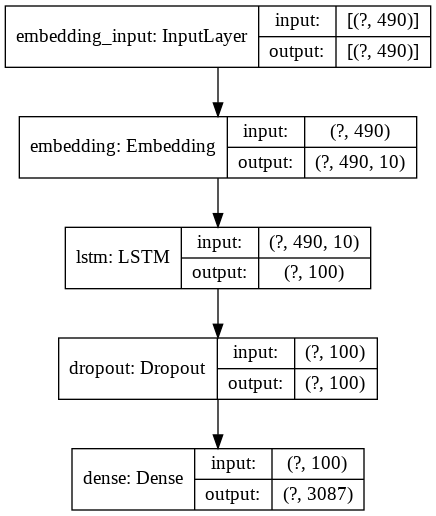

In [ ]:
plot_model(model,show_shapes = True)

In [ ]:
model.fit(X_input,y_output,epochs = 100,batch_size = 128 )

Epoch 1/100
183/183 [==============================] - 163s 890ms/step - loss: 6.7244
Epoch 2/100
183/183 [==============================] - 163s 892ms/step - loss: 6.3517
Epoch 3/100
183/183 [==============================] - 164s 896ms/step - loss: 6.2989
Epoch 4/100
183/183 [==============================] - 164s 894ms/step - loss: 6.2615
Epoch 5/100
183/183 [==============================] - 164s 896ms/step - loss: 6.2134
Epoch 6/100
183/183 [==============================] - 163s 891ms/step - loss: 6.1516
Epoch 7/100
183/183 [==============================] - 164s 894ms/step - loss: 6.0821
Epoch 8/100
183/183 [==============================] - 163s 891ms/step - loss: 6.0039
Epoch 9/100
183/183 [==============================] - 164s 893ms/step - loss: 5.9286
Epoch 10/100
183/183 [==============================] - 163s 890ms/step - loss: 5.8496
Epoch 11/100
183/183 [==============================] - 163s 891ms/step - loss: 5.7728
Epoch 12/100
183/183 [==============================

In [9]:
from tensorflow.keras.models import load_model
filepath_to_model = '/content/drive/My Drive/Colab Notebooks/NLP/Hotel_description_generator/hotel_desc.h5'
saved_model = load_model(filepath_to_model)

In [10]:
saved_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 490, 10)           30870     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3087)              311787    
Total params: 387,057
Trainable params: 387,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk 
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

def generate_seq(model, tokenizer,seq_length,seed_text ,n_words):
  # empty list too append our predicted output  
  result = []
  in_text = seed_text
  for _ in range(n_words):
    # encode the text as integer
    encoded = tokenizer.texts_to_sequences([in_text])[0]

    # truncate the sequence to fixed length 
    # because we are adding the new output text to the end of our previous input text, 
    # we will always remove a word from the start of the input text to ensure that the size 
    # remains at 50 
    encoded = pad_sequences([encoded], maxlen = seq_length, truncating = "pre")
    # use predict_class 
    #yhat = model.predict_classes(encoded, verbose = 0)
    yhat = np.argmax(model.predict(encoded),axis = 1)
    out_word = ""
    for word,index in tokenizer.word_index.items():
      if index == yhat:
        out_word = word 
        break
      # append to input 
    in_text += " "+ out_word
    result.append(out_word)
  return " ".join(result)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
seed_text = "Downtown "
generated = generate_seq(saved_model,tokenizer,max_seq_length,seed_text,100)
print(seed_text + generated)


Downtown seattle premier renovated hotel in seattle wa is just minutes from the seattle tacoma international airport making the seattle skyline and the intrinsic beauty of seattle and elevates the refined edge of the city and the city has to offer the ballard inn offers full service breakfast is available in the most renamed the inn has to offer guests at the marqueen hotel in the heart of the city and the city awaits you re to sushi you with the city of seattle cultural unique style hotel is located in the heart of downtown seattle the camlin is located in
